"Build a system that can classify if a transaction is fraudulent or not."
→ The provided code builds a binary classification system using a Random Forest model that learns from transaction data to predict whether TX_FRAUD = 0 (legit) or TX_FRAUD = 1 (fraud).



The below code are applicable for Fraud scenarios like

1. "Any transaction whose amount is more than 220 is a fraud."

Addressed by:

-- Including TX_AMOUNT directly as a feature in the model

-- The model can learn that higher amounts (especially >220) are strong indicators of fraud

Why it works: Random Forests can detect this obvious pattern during training.

2. "Two terminals per day generate fraudulent transactions for 28 days."

Partially addressed by:

-- Including TX_DAY, TX_HOUR, and TX_WEEKDAY as features (to give the model some time context)

-- Terminal-specific fraud patterns are not explicitly engineered yet — but can be added via:

--> Terminal-level rolling fraud count (optional enhancement)
credit_card_data['TERMINAL_TX_COUNT'] = credit_card_data.groupby('TERMINAL_ID')['TX_AMOUNT'].transform('count')
Recommendation: Add a rolling fraud rate per terminal over past N days to explicitly capture this pattern.

3. "3 random customers have 1/3 of their transactions increased 5× and marked as fraud."

Partially addressed by:

-- Including TX_AMOUNT and total transaction count per customer (CUSTOMER_TX_COUNT) as features

-- Better approach: Add features like average transaction amount per customer, and transaction deviation:

--> Avg amount per customer
avg_tx = credit_card_data.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('mean')
credit_card_data['TX_AMOUNT_DEV'] = credit_card_data['TX_AMOUNT'] / (avg_tx + 1e-5)

This helps detect when a transaction is 5× a customer's normal spending pattern.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install chardet
import chardet

# Read the raw binary and detect encoding
with open('/content/drive/MyDrive/Projects/fraud_detection/dataset.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))  # sample 10,000 bytes
    print(result)


{'encoding': None, 'confidence': 0.0, 'language': None}


In [ ]:
with open('/content/drive/MyDrive/Projects/fraud_detection/dataset.csv', 'rb') as f:
    raw_bytes = f.read(100)
    print(raw_bytes)


b'PK\x03\x04\x14\x00\x00\x00\x00\x00}w\xa3R\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00data/PK\x03\x04\x14\x00\x00\x00\x08\x00}w\xa3RR\x96\xbd\xa2\xa0p\x02\x00g\x96\x08\x00\x13\x00\x00\x00data/2018-04-01.pkll\xddS\x18$\xcd\x15\x00\xd0\xacm\xdb\xb6m\xdb\xc9'


Since the dataset.csv file is a zip file we extract the file as filename: "extracted_data" and end up as ".pkl" extension file which makes the data to easily extracted

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Projects/fraud_detection/dataset.csv'  # actually a .zip
extract_path = '/content/extracted_data'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List files that were extracted
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)


Extracted files: ['data']


In [ ]:
import os

extract_path = '/content/extracted_data'
extracted_files = []

# Recursively find all files in extracted directory
for root, dirs, files in os.walk(extract_path):
    for file in files:
        extracted_files.append(os.path.join(root, file))

# Show the list
for f in extracted_files:
    print(f)


/content/extracted_data/data/2018-09-20.pkl
/content/extracted_data/data/2018-09-06.pkl
/content/extracted_data/data/2018-06-05.pkl
/content/extracted_data/data/2018-05-15.pkl
/content/extracted_data/data/2018-05-29.pkl
/content/extracted_data/data/2018-04-15.pkl
/content/extracted_data/data/2018-09-24.pkl
/content/extracted_data/data/2018-05-30.pkl
/content/extracted_data/data/2018-05-09.pkl
/content/extracted_data/data/2018-05-26.pkl
/content/extracted_data/data/2018-07-17.pkl
/content/extracted_data/data/2018-08-12.pkl
/content/extracted_data/data/2018-04-01.pkl
/content/extracted_data/data/2018-08-29.pkl
/content/extracted_data/data/2018-05-10.pkl
/content/extracted_data/data/2018-08-22.pkl
/content/extracted_data/data/2018-07-31.pkl
/content/extracted_data/data/2018-08-24.pkl
/content/extracted_data/data/2018-09-27.pkl
/content/extracted_data/data/2018-06-01.pkl
/content/extracted_data/data/2018-09-09.pkl
/content/extracted_data/data/2018-08-03.pkl
/content/extracted_data/data/201

In [ ]:
import pandas as pd

credit_card_data = pd.read_pickle('/content/extracted_data/data/2018-04-01.pkl')


In [ ]:
!ls /content/

drive  extracted_data  sample_data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# Already loaded
# credit_card_data = pd.read_pickle('/content/extracted_data/data/2018-04-01.pkl')

# Preview the data
credit_card_data.head()


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64
       TRANSACTION_ID                    TX_DATETIME    TX_AMOUNT  \
count     9488.000000                           9488  9488.000000   
mean      4743.500000  2018-04-01 12:01:31.743676416    53.249981   
min          0.000000            2018-04-01 00:00:31     0.130000   
25%       2371.750000            2018-04-01 08:25:20    21.197500   
50%       4743.500000            2018-04-01 12:00:24    45.590000   
75%       7115.250000  2018-04-01 15:37:57.249999872    76.932500   
max       9487.000000            2018-04-01 23:59:51   226.400000   
std       2739.094011                            NaN    39.504071   

          TX_FRAUD  TX_FRAUD_SCENARIO  
count  9488.000000        9488.000000  
mean      0.000316           0.000316  
min       0.000000           0.000000 

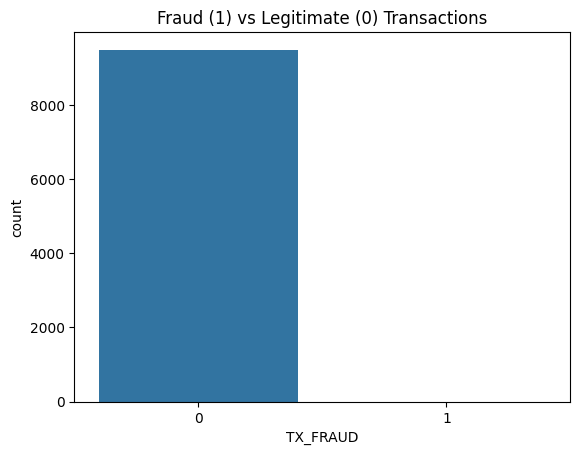

In [ ]:
# Check for missing values
print(credit_card_data.isnull().sum())

# Basic statistics
print(credit_card_data.describe())

# Class distribution
sns.countplot(data=credit_card_data, x='TX_FRAUD')
plt.title("Fraud (1) vs Legitimate (0) Transactions")
plt.show()


In [ ]:
# Convert TX_DATETIME to datetime type
credit_card_data['TX_DATETIME'] = pd.to_datetime(credit_card_data['TX_DATETIME'])

# Create useful time-based features
credit_card_data['TX_DAY'] = credit_card_data['TX_DATETIME'].dt.day
credit_card_data['TX_HOUR'] = credit_card_data['TX_DATETIME'].dt.hour
credit_card_data['TX_WEEKDAY'] = credit_card_data['TX_DATETIME'].dt.weekday

# Aggregated features (customer's and terminal's fraud rates or counts)
customer_txn_count = credit_card_data.groupby('CUSTOMER_ID')['TX_AMOUNT'].count().reset_index()
customer_txn_count.columns = ['CUSTOMER_ID', 'CUSTOMER_TX_COUNT']

credit_card_data = credit_card_data.merge(customer_txn_count, on='CUSTOMER_ID', how='left')


In [ ]:
# Select features
features = ['TX_AMOUNT', 'TX_DAY', 'TX_HOUR', 'TX_WEEKDAY', 'CUSTOMER_TX_COUNT']
X = credit_card_data[features]
y = credit_card_data['TX_FRAUD']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
#Training a classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)


In [ ]:
# Evaluation of model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[1897    0]
 [   1    0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1897
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1898
   macro avg       0.50      0.50      0.50      1898
weighted avg       1.00      1.00      1.00      1898


Accuracy Score: 0.9994731296101159


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


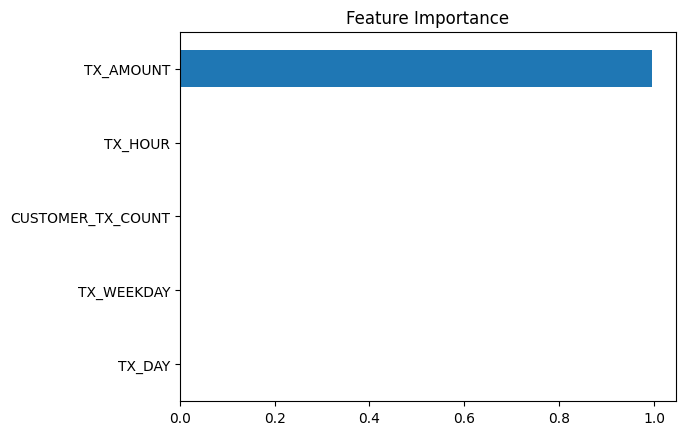

In [ ]:
#Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()
